In [27]:
import pywt
import wfdb
import pandas as pd
import numpy as np
from scipy import signal, fftpack
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats as set_fmt
set_fmt('svg')         
import warnings  
warnings.filterwarnings("ignore", category=DeprecationWarning)


## Load and plot ECG signal

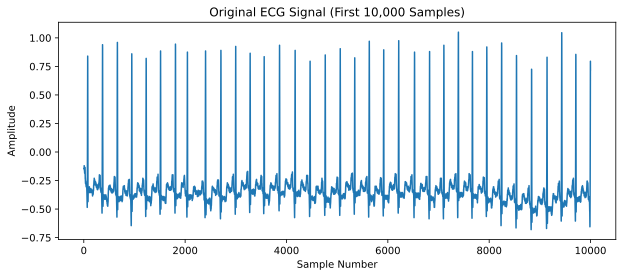

In [28]:
recordName = 'mit-bih-arrhythmia-database/100'
sig, fields = wfdb.rdsamp(record_name=recordName)
sig = sig[:10000, 0]  # Use the first 10,000 samples for analysis
fs = fields['fs']  # Sampling frequency of the ECG signal

# Plot original ECG signal
plt.figure(figsize=(10, 4))
plt.plot(sig)
plt.title("Original ECG Signal (First 10,000 Samples)")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.show()

# Pan-Tompkins Algorithm Step-by-Step



## Step 1: Bandpass filtering (0.5-20 Hz) to remove baseline drift and high-frequency noise

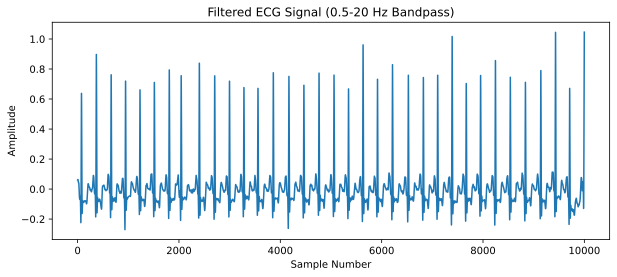

In [29]:
fl = 0.5  # Low cutoff frequency for high-pass filter
fh = 20   # High cutoff frequency for low-pass filter
b1, a1 = signal.butter(3, fh / (fs / 2), 'low')
b2, a2 = signal.butter(3, fl / (fs / 2), 'high')

sig_filter = signal.filtfilt(b1, a1, sig, padtype='even')
sig_filter = signal.filtfilt(b2, a2, sig_filter, padtype='even')

# Plot filtered ECG signal
plt.figure(figsize=(10, 4))
plt.plot(sig_filter)
plt.title("Filtered ECG Signal (0.5-20 Hz Bandpass)")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.show()


## Step 2: Calculate the derivative to emphasize QRS slope information

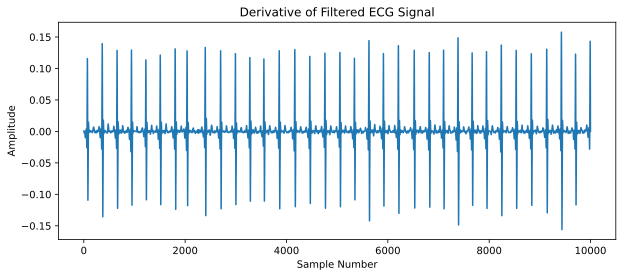

In [30]:
sig_derivate = np.diff(sig_filter, n=1, append=sig_filter[-1])


# Plot derivative of the filtered signal
plt.figure(figsize=(10, 4))
plt.plot(sig_derivate)
plt.title("Derivative of Filtered ECG Signal")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.show()

In [32]:
# Step 3: Square the signal to make all data points positive and enhance larger differences

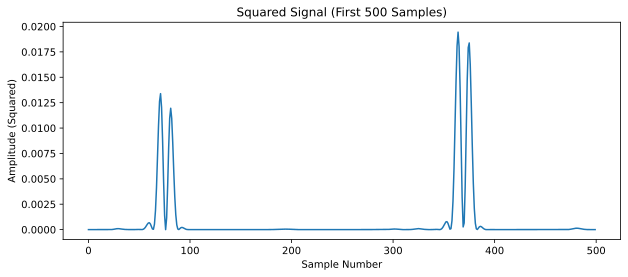

In [31]:
sig_square = np.square(sig_derivate)


# Plot squared signal
plt.figure(figsize=(10, 4))
plt.plot(sig_square[:500])
plt.title("Squared Signal (First 500 Samples)")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude (Squared)")
plt.show()


## Step 4: Moving average to smooth the squared signal

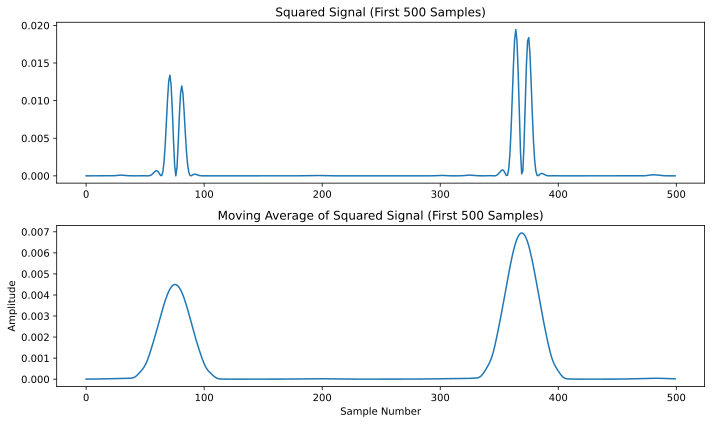

In [34]:
# Kernel size based on a 150ms window
kernel_size = round(0.15 * fs) + 1
kernel = np.hamming(kernel_size)
kernel = kernel / np.sum(kernel)


# Apply moving average with symmetric padding
n = int(kernel_size / 2)
sig_pad = np.pad(sig_square, pad_width=[n], mode='symmetric')
sig_moving = np.zeros_like(sig_square)


for i in range(n, sig_pad.shape[0] - n):
    tp = sig_pad[i - n:i + n + 1]
    tp = np.sum(tp * kernel)
    sig_moving[i - n] = tp

    
    
    
# Plot squared signal and moving average
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(sig_square[:500])
plt.title("Squared Signal (First 500 Samples)")

plt.subplot(2, 1, 2)
plt.plot(sig_moving[:500])
plt.title("Moving Average of Squared Signal (First 500 Samples)")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


## Step 5: Peak detection to identify R-peaks in the ECG signal

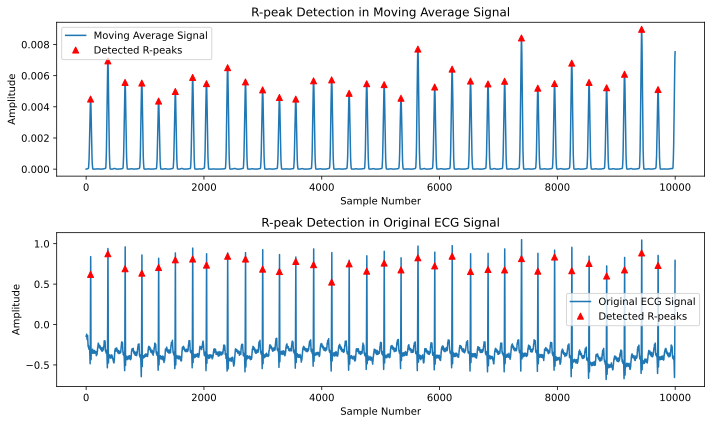

In [36]:
locs = signal.find_peaks(sig_moving, height=np.mean(sig_moving), distance=0.6 * fs)[0]




# Plot detected peaks in moving average signal
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(sig_moving, label='Moving Average Signal')
plt.plot(locs, sig_moving[locs], 'r^', label='Detected R-peaks')
plt.title("R-peak Detection in Moving Average Signal")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.legend()

# Plot detected peaks in original ECG signal
plt.subplot(2, 1, 2)
plt.plot(sig, label='Original ECG Signal')
plt.plot(locs, sig[locs], 'r^', label='Detected R-peaks')
plt.title("R-peak Detection in Original ECG Signal")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.legend()



plt.tight_layout()
plt.show()
